<div hidden>
    $\newcommand{\q}{\left}$
    $\newcommand{\w}{\right}$
    $\newcommand{\m}{\middle}$
    $\newcommand{\e}{\boldsymbol}$
    $\newcommand{\cb}{\mspace{3mu}\m\vert\mspace{3mu}}$
</div>

<center>
    Sveučilište u Zagrebu<br>
    Fakultet elektrotehnike i računarstva<br>
    <a href="http://www.fer.unizg.hr/predmet/map">Multivarijatna analiza podataka</a><br>
    Ak. god. 2022./23.    
</center>

<h1>
    Laboratorijska vježba 3: <br> Diskriminantna analiza, metode grupiranja i udaljenosti, analiza korespondencije
</h1>

---

## Uvod i upute za predaju

Rješavanje vježbe svodi se na čitanje uputa u ćelijama s tekstom, nadopunjavanje blokova kôda (možete dodavati i dodatne blokove kôda ukoliko je potrebno) i ispisivanje rezultata (u vidu ispisa iz funkcija, tablica i grafova). Vježbu radite samostalno, a svoje rješenje branite na terminima koji su vam dodijeljeni u kalendaru. **Pritom morate razumjeti teorijske osnove implementiranih rješenja, u okviru onoga što je obrađeno na predavanjima, te morate pokazati da razumijete sav kôd koji ste napisali.** Zadatci u samoj vježbi su istraživačkog tipa  &mdash; ne postoji nužno samo jedan točan način rješavanja svakog zadatka, zato potičemo studente na eksperimentiranje.

Kôd možete pisati u Python ili R programskim jezicima. Ukoliko želite koristiti R, potrebno je instalirati određeni paket prema [ovim jednostavnim uputama](https://datatofish.com/r-jupyter-notebook/), i zatim odabrati R kernel u gornjem desnom kutu. **Osim ako u određenom zadatku ne piše drugačije, za implementaciju rješenja možete koristiti proizvoljne biblioteke.**

**Vaše rješenje potrebno je predati u sustav _Moodle_ u obliku .ipynb datoteke naziva IME_PREZIME_JMBAG.ipynb.** Podsjećamo da bodovi iz laboratorijskih vježbi ulaze i u bodove na ispitnom roku, te da je za polaganje predmeta potrebno imati barem 50% ukupnih bodova iz laboratorijskih vježbi. **Nadoknade laboratorijskih vježbi neće biti organizirane.** Za sva dodatna pitanja svakako se javite na email adresu predmeta: _map@fer.hr_.

---

## Podatkovni skup

U ovoj laboratorijskoj vježbi analizirat ćemo skup podataka s oko 1500 najpoznatijih klasičnih skladbi prema glasovima korisnika stranice [classicalmusiconly.com](https://classicalmusiconly.com/).
Opis varijabli dan je u tablici u nastavku:

<table>
    <thead>
        <tr>
            <th>Naziv stupca</th>
            <th>Opis</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td><code>title</code></td>
            <td>naziv skladbe</td>
        </tr>
        <tr>
            <td><code>category</code></td>
            <td>kategorija kojoj skladba pripada<br>(sonata, simfonija, itd.)</td>
        </tr>
        <tr>
            <td><code>composer</code></td>
            <td>ime skladatelja</td>
        </tr>
        <tr>
            <td><code>year</code></td>
            <td>godina kada je skladba napisana</td>
        <tr>
            <td><code>epoch</code></td>
            <td>stilsko razdoblje</td>
        </tr>
        <tr>
            <td><code>country</code></td>
            <td>država rođenja skladatelja</td>
        <tr>
            <td><code>stars</code></td>
            <td>broj glasova <br> (koliko korisnika je označilo skladbu kao favorit))</td>
        </tr>
    </tbody>
</table>

---

Učitajte datoteku `classical_data.csv` i proučite podatke.
Varijable `category`, `composer`, `epoch` i `country` treba tretirati kao da se radi o kategorijskim varijablama.
Ispišite nekoliko redaka iz tablice.

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import sklearn
import scipy as sp
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.linear_model import LinearRegression, RidgeClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import csv
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import pdist, squareform
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
# Load the data
df = pd.read_csv('classical_data.txt')

# Check the data
#print(df.head())
#print()
#print(df.info())
#print()
#print(df.describe())

df = df.iloc[:, 1:] #remove the unnamed column

# Check the modified DataFrame
print(df.head())
print()
print(df.info())
print()
print(df.describe())

                                    title         category  \
0  The Four Seasons (Le Quattro Stagioni)  Violin Concerto   
1              Requiem in D Minor, K. 626   Mass / Requiem   
2      Symphony No. 9 in D Minor, Op. 125         Symphony   
3                               Nocturnes     Piano Sonata   
4                       Swan Lake, Op. 20           Ballet   

                   composer  year           epoch  country  stars  
0           Antonio Vivaldi  1723         Baroque    Italy   2515  
1   Wolfgang Amadeus Mozart  1791       Classical  Austria   2122  
2      Ludwig van Beethoven  1824  Early Romantic  Germany   2084  
3           Frédéric Chopin  1846        Romantic   Poland   1999  
4  Pyotr Ilyich Tchaikovsky  1876        Romantic   Russia   1335  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1532 entries, 0 to 1531
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     1532 non-null   objec

---

## 1. Grupiranje

U ovom zadatku ćemo grupirati kategorije skladbi na temelju njihove sličnosti.

<b>a)</b> Izračunajte i prikažite <b>kontingencijsku tablicu</b> $\mathbf C$ između <b>skladatelja</b> i <b>kategorija.</b> Element kontingencijske tablice $C_{i, j}$ odgovara ukupnom broju skladbi u $j$-toj kategoriji koje je napisao $i$-ti skladatelj.

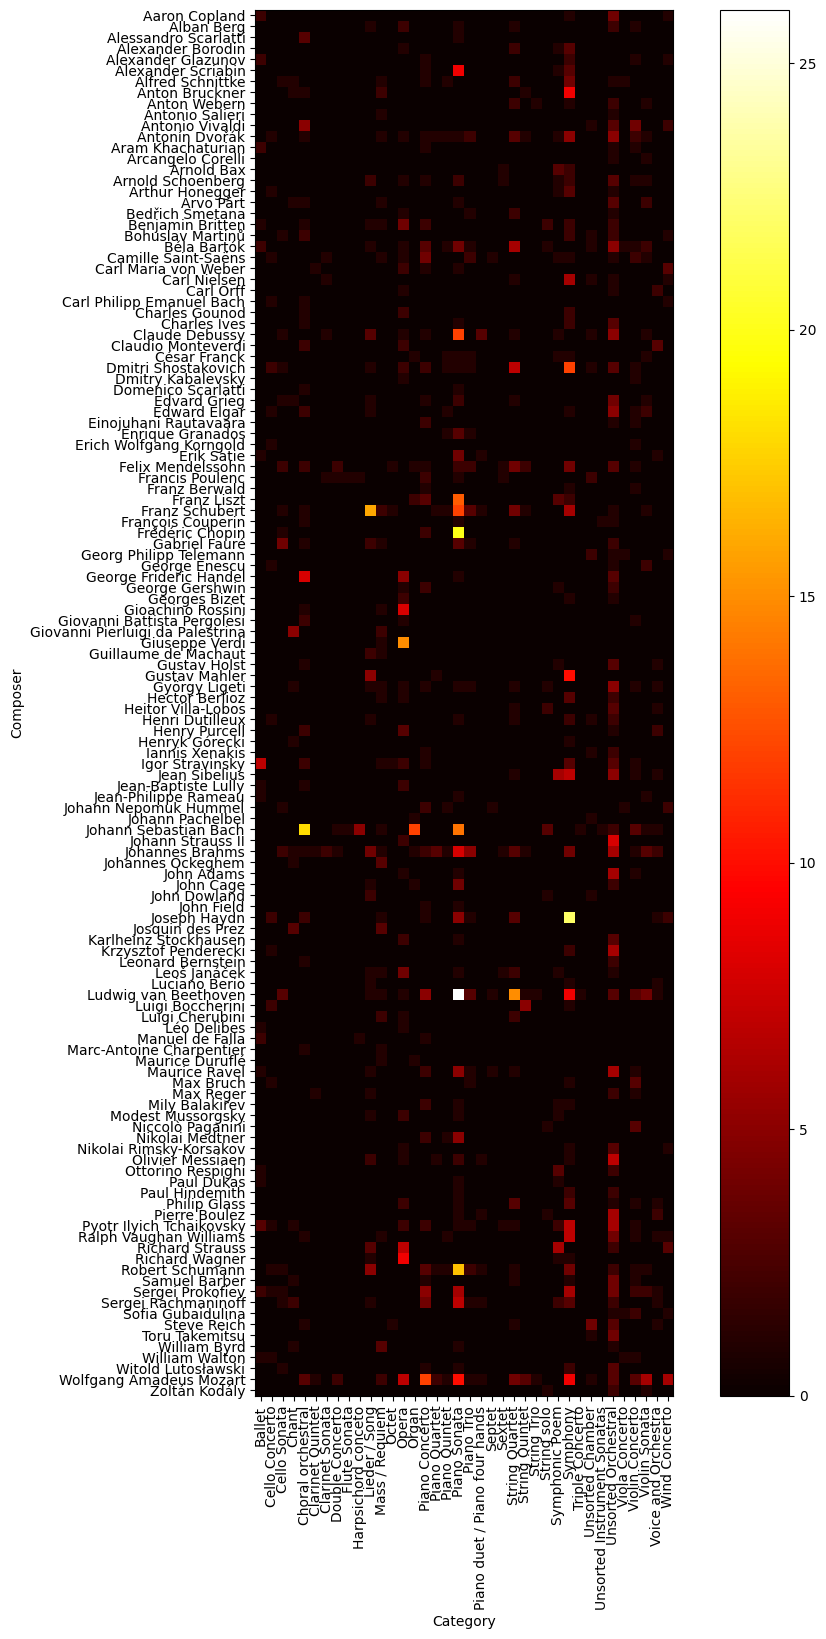

In [3]:
# Calculate contingency table
contingency_table = pd.crosstab(df['composer'], df['category'])

# Create heatmap
plt.figure(figsize=(12, 18))
plt.imshow(contingency_table, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks

plt.xlabel('Category')
plt.ylabel('Composer')
plt.xticks(range(len(contingency_table.columns)), contingency_table.columns, rotation=90)
plt.yticks(range(len(contingency_table.index)), contingency_table.index)

# Show the plot
plt.show()

---

Prije nego što nastavimo s grupiranjem, željeli bismo smanjiti broj kategorija koje ćemo uzeti u obzir. <br>
<b>b)</b> Grafički prikažite ukupan broj skladbi po pojedinoj kategoriji, <i>sortirano</i> uzlazno.
Zatim proizvoljno odredite prag, te izbacite sve kategorije (stupce kontingencijske tablice) koje po Vašem kriteriju sadrže premalo skladbi.
Ako nakon izbacivanja u tablici preostanu skladatelji koji imaju ukupno 0 skladbi, izbacite i takve retke. <br>
<b>Prikažite dobivenu tablicu i graf temeljem kojega ste odredili prag.</b>

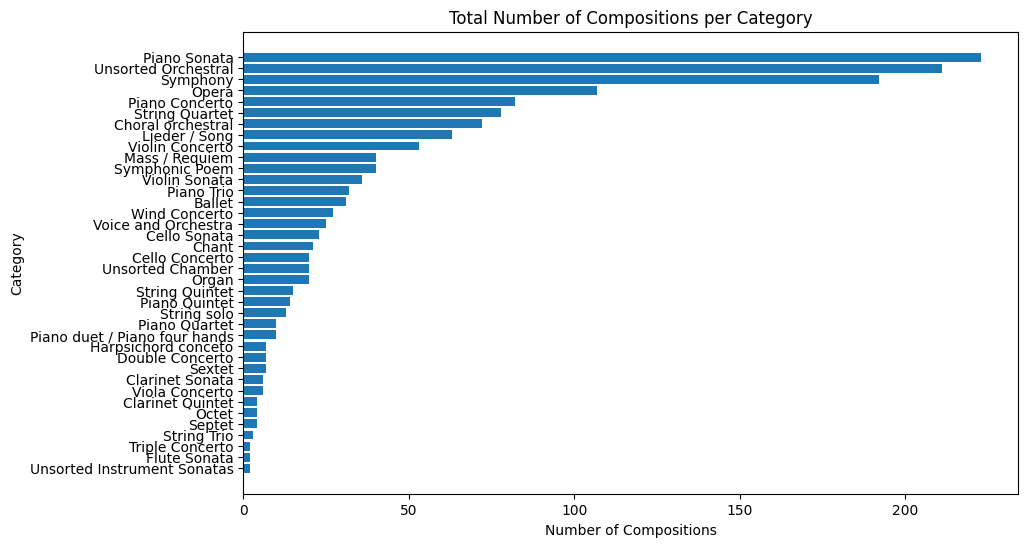

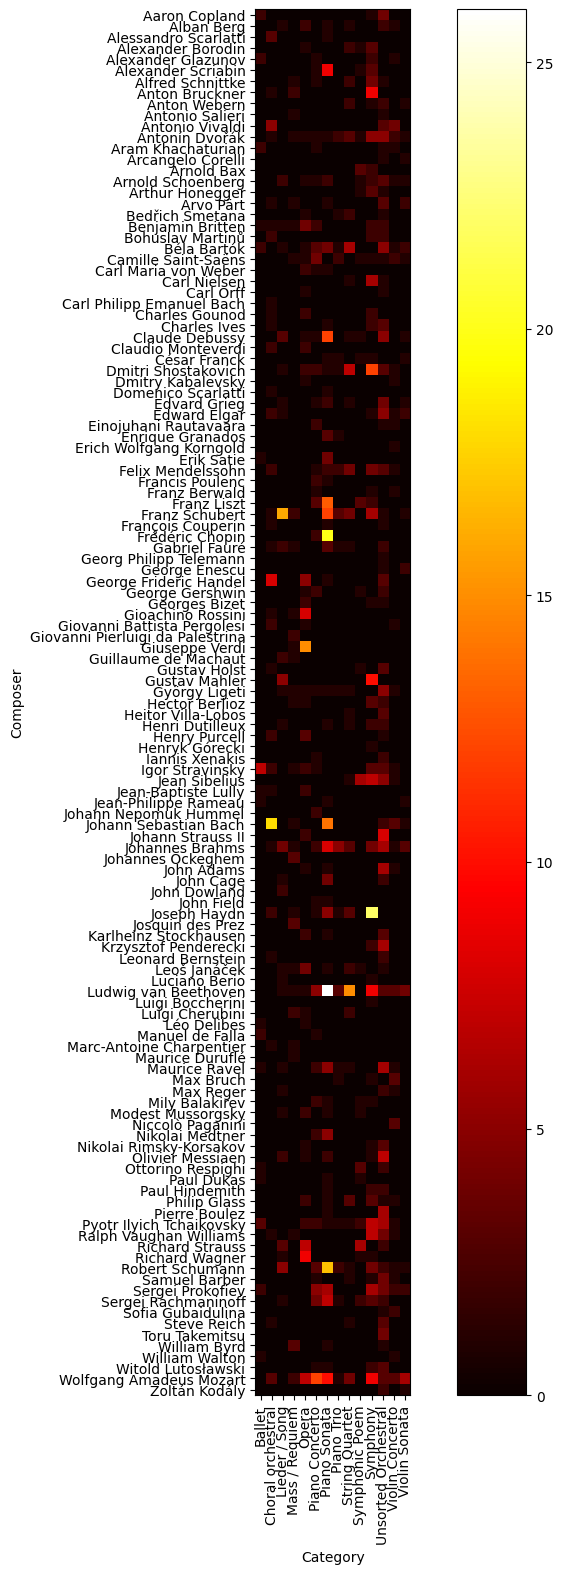

In [4]:
# Calculate the total number of compositions per category
category_counts = df['category'].value_counts().sort_values()

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.barh(category_counts.index, category_counts.values)

# Set labels and title
plt.xlabel('Number of Compositions')
plt.ylabel('Category')
plt.title('Total Number of Compositions per Category')

# Show the plot
plt.show()
print()

# Calculate the total number of compositions per category
category_counts = df['category'].value_counts()

# Filter categories with less than 30 compositions
filtered_df = df[df['category'].isin(category_counts[category_counts >= 30].index)]

# Calculate the total number of compositions per composer in the filtered dataset
composer_counts = filtered_df['composer'].value_counts()

# Filter composers with 0 compositions
filtered_df = filtered_df[filtered_df['composer'].isin(composer_counts[composer_counts > 0].index)]

# Calculate contingency table
contingency_table2 = pd.crosstab(filtered_df['composer'], filtered_df['category'])

# Create heatmap
plt.figure(figsize=(12, 18))
plt.imshow(contingency_table2, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks

plt.xlabel('Category')
plt.ylabel('Composer')
plt.xticks(range(len(contingency_table2.columns)), contingency_table2.columns, rotation=90)
plt.yticks(range(len(contingency_table2.index)), contingency_table2.index)

# Show the plot
plt.show()


---

<b>c)</b> Provedite hijerarhijsko aglomerativno grupiranje (engl. <i>hierarchical agglomerative clustering</i>) nad <b>kategorijama.</b> Kao mjeru udaljenosti među kategorijama koristite <b>kosinusnu udaljenost</b> među stupcima kontingencijske tablice koju ste prethodno izračunali. Isprobajte različite metode za <b>spajanje grupa</b> (engl. <i>linkage</i>), te:
<ol>
    <li><b>nacrtajte dendrogram</b> za dobiveno grupiranje (vidi <a href="https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html">poveznicu</a> za pomoć),</li>
    <li>prema dendrogramu <b>odredite broj grupa.</b></li>
</ol>
<b>Odaberite jednu metodu povezivanja</b> koja Vam daje rezultate koje najlakše možete interpretirati.
U obzir uzmite balansiranost veličina klastera.
<b>Prikažite dendrogram</b> i <b>ispišite nazive kategorija</b> u pojedinoj grupi u konačnom rezultatu grupiranja.

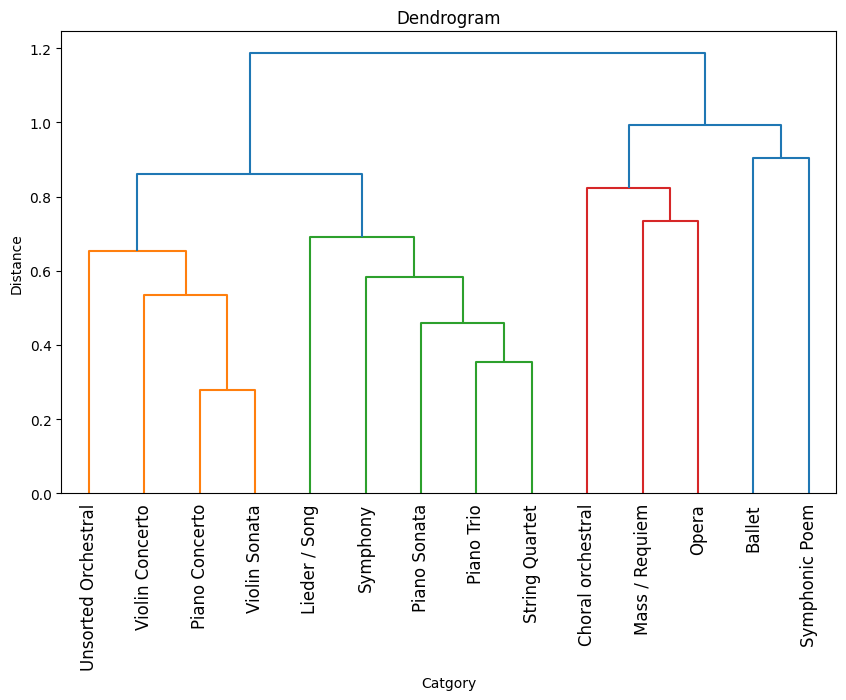

In [5]:
distances = pdist(contingency_table2.values.T, metric='cosine')
#print(type(distances))

methods = ['single', 'complete', 'average', 'ward']
selected_method = 'ward'  # select a method

linkage_matrix = linkage(distances, method=selected_method)
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix, labels=contingency_table2.columns, orientation='top')
plt.title('Dendrogram')
plt.xlabel('Catgory')
plt.ylabel('Distance')
plt.xticks(rotation=90)
plt.show()
print()

---

## 2. Linearna diskriminantna analiza

U ovom zadatku želimo vizualizirati klasifikaciju skladatelja s obzirom na to kojem stilskom razdoblju pripadaju, koristeći izvedene značajke temeljene na kategorijama skladbi koje su pisali.

---

<b>a)</b> Izračunajte i prikažite <b>kontingencijsku tablicu</b> $\mathbf C$ između <b>skladatelja</b> i <b>kategorija.</b> Element kontingencijske tablice $C_{i, j}$ odgovara ukupnom broju skladbi u $j$-toj kategoriji koje je napisao $i$-ti skladatelj, kao i u <b>1. a)</b>. Zatim, standardizirajte retke kontingencijske tablice na način da od svakog retka oduzmete njegovu srednju vrijednost, te ga podijelite s njegovom standardnom devijacijom.
<b>Prikažite ovako standardiziranu tablicu</b> te se uvjerite da su srednje vrijednosti svih redaka jednake 0 i njihove devijacije jednake 1.

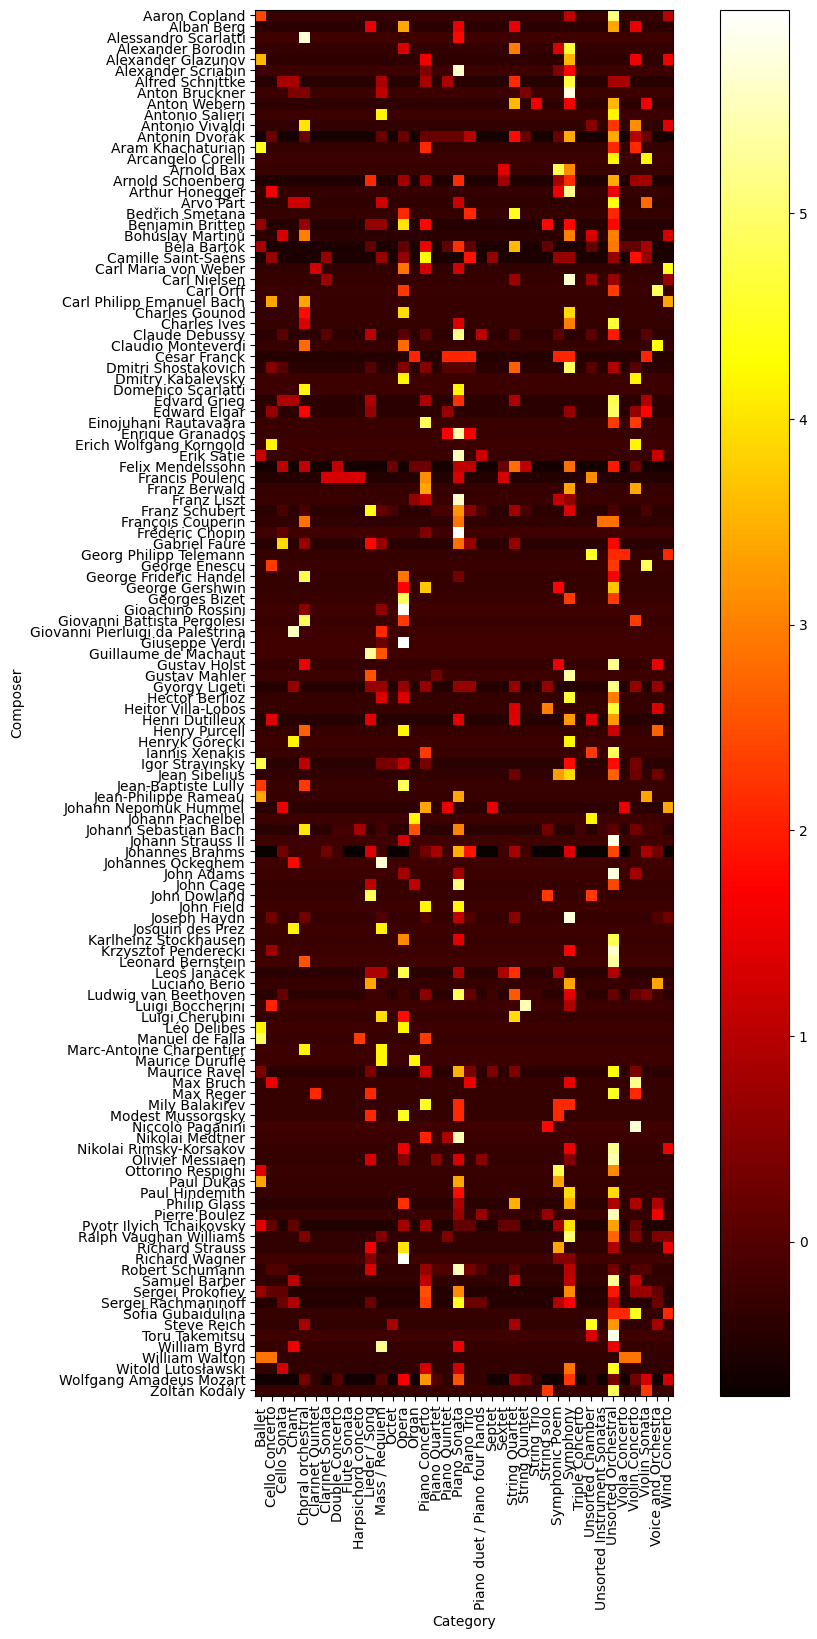

In [6]:
# Calculate the contingency table
contingency_table = pd.crosstab(df['composer'], df['category'])

# Normalize the contingency table
standardized_table = (contingency_table - contingency_table.mean(axis=1).values.reshape(-1, 1)) / contingency_table.std(axis=1).values.reshape(-1, 1)


# Plot the normalized contingency table with heatmap
plt.figure(figsize=(12, 18))
plt.imshow(standardized_table, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks
plt.xlabel('Category')
plt.ylabel('Composer')
plt.xticks(range(len(standardized_table.columns)), standardized_table.columns, rotation=90)
plt.yticks(range(len(standardized_table.index)), standardized_table.index)

# Show the plot
plt.show()

In [7]:
print(standardized_table.std(axis=1))
print(standardized_table.mean(axis=1))

composer
Aaron Copland              1.0
Alban Berg                 1.0
Alessandro Scarlatti       1.0
Alexander Borodin          1.0
Alexander Glazunov         1.0
                          ... 
William Byrd               1.0
William Walton             1.0
Witold Lutosławski         1.0
Wolfgang Amadeus Mozart    1.0
Zoltán Kodály              1.0
Length: 126, dtype: float64
composer
Aaron Copland              4.674623e-17
Alban Berg                 3.213803e-17
Alessandro Scarlatti      -5.112869e-17
Alexander Borodin          2.337312e-17
Alexander Glazunov         5.843279e-17
                               ...     
William Byrd              -2.629476e-17
William Walton             4.382459e-17
Witold Lutosławski         1.343954e-16
Wolfgang Amadeus Mozart    1.752984e-17
Zoltán Kodály              8.764919e-17
Length: 126, dtype: float64


---

<b>b)</b> Provedite postupak višeklasne <b>linearne diskriminantne analize</b>.
Klasificirajte skladatelje prema stilskom razdoblju kojem pripadaju (jedan skladatelj pripada samo jednom razdoblju), koristeći stupce prethodno standardizirane kontingencijske tablice iz 2. b) kao značajke.<br>
<b>Prikažite graf raspršenja</b> koristeći prve dvije diskriminante, gdje jedna točka predstavlja jednog skladatelja.
Različitom bojom prikažite različite klase. <br>
<b>Ispišite</b> udjele objašnjene varijance za sve diskriminante. <br>
Koje klase se najbolje razdvajaju od ostalih na dobivenom prikazu?

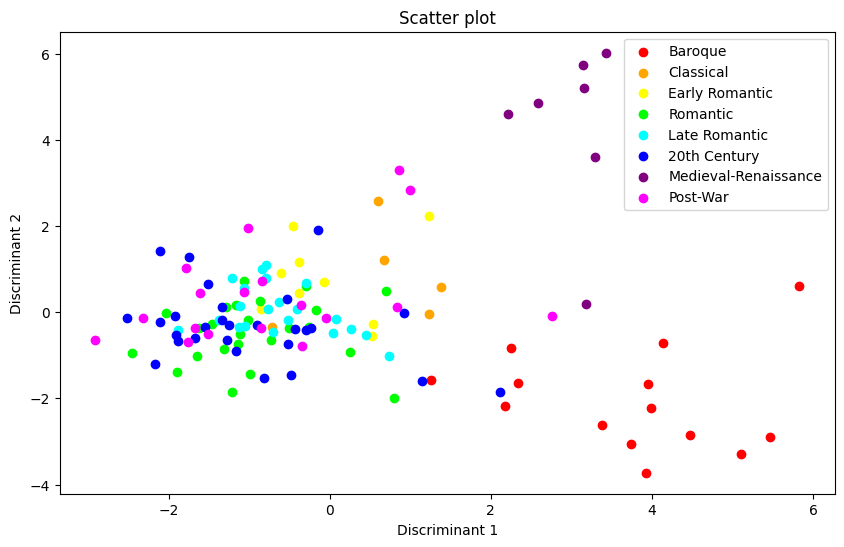

Explained Variance Ratio:
Discriminant 1: 36.11%
Discriminant 2: 23.22%


In [8]:

epochs = df['epoch'].unique()

target_classes = df.groupby('composer')['epoch'].first()
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(standardized_table, target_classes)
transformed_data = lda.transform(standardized_table)
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#800080', '#FF00FF']
plt.figure(figsize=(10, 6))
i=0
for style in epochs:
    plt.scatter(transformed_data[target_classes == style, 0], transformed_data[target_classes == style, 1], label=style, c=colors[i])
    i+=1
plt.xlabel('Discriminant 1')
plt.ylabel('Discriminant 2')
plt.title('Scatter plot')
plt.legend()
plt.show()

explained_variance_ratio = lda.explained_variance_ratio_

# Print the explained variance ratio
print("Explained Variance Ratio:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"Discriminant {i+1}: {variance * 100:.2f}%")

---

<b>c)</b> Ponovite postupak višeklasne <b>linearne diskriminantne analize</b>, ovaj put nad reduciranim skupom podataka koji sadrži samo sljedeća stilska razdoblja:
`
["Baroque", "Classical", "Early Romantic", "Romantic", "Late Romantic"]
`. <br>
<b>Prikažite graf raspršenja</b> koristeći prve dvije diskriminante, gdje jedna točka predstavlja jednog skladatelja.
Različitom bojom prikažite različite klase. <br>
<b>Ispišite</b> udjele objašnjene varijance za sve diskriminante. <br>
Komentirajte kvalitetu dobivenog prikaza u odnosu na prethodni podzadatak.

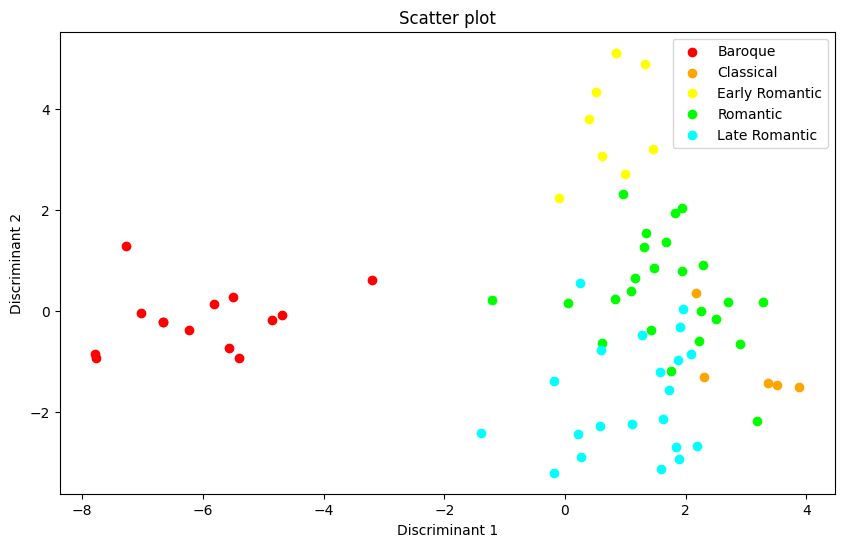

Explained Variance Ratio:
Discriminant 1: 61.15%
Discriminant 2: 19.09%


In [9]:
# Define the list of allowed epochs
allowed_epochs = ["Baroque", "Classical", "Early Romantic", "Romantic", "Late Romantic"]

# Filter the 'epoch' column
filtered_df = df[df['epoch'].isin(allowed_epochs)]
# Calculate the contingency table
contingency_table = pd.crosstab(filtered_df['composer'], filtered_df['category'])

# Normalize the contingency table
standardized_table = (contingency_table - contingency_table.mean(axis=1).values.reshape(-1, 1)) / contingency_table.std(axis=1).values.reshape(-1, 1)
#epochs = filtered_df['epoch'].unique()

target_classes = filtered_df.groupby('composer')['epoch'].first()
lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(standardized_table, target_classes)
transformed_data = lda.transform(standardized_table)
colors = ['#FF0000', '#FFA500', '#FFFF00', '#00FF00', '#00FFFF', '#0000FF', '#800080', '#FF00FF']
plt.figure(figsize=(10, 6))
i=0
for style in allowed_epochs:
    plt.scatter(transformed_data[target_classes == style, 0], transformed_data[target_classes == style, 1], label=style, c=colors[i])
    i+=1
plt.xlabel('Discriminant 1')
plt.ylabel('Discriminant 2')
plt.title('Scatter plot')
plt.legend()
plt.show()

explained_variance_ratio = lda.explained_variance_ratio_

# Print the explained variance ratio
print("Explained Variance Ratio:")
for i, variance in enumerate(explained_variance_ratio):
    print(f"Discriminant {i+1}: {variance * 100:.2f}%")

## 3. Višedimenzionalno skaliranje

U ovom zadatku želimo vizualizirati sličnosti između pojedinih stilskih razdoblja koristeći metričko i nemetričko skaliranje.

---

<b>a)</b>
**Izračunajte i prikažite** kontingencijsku tablicu za varijable `category` i `epoch` (stilsko razdoblje).
Neka retci sadrže kategorije, a stupci stilska razdoblja.

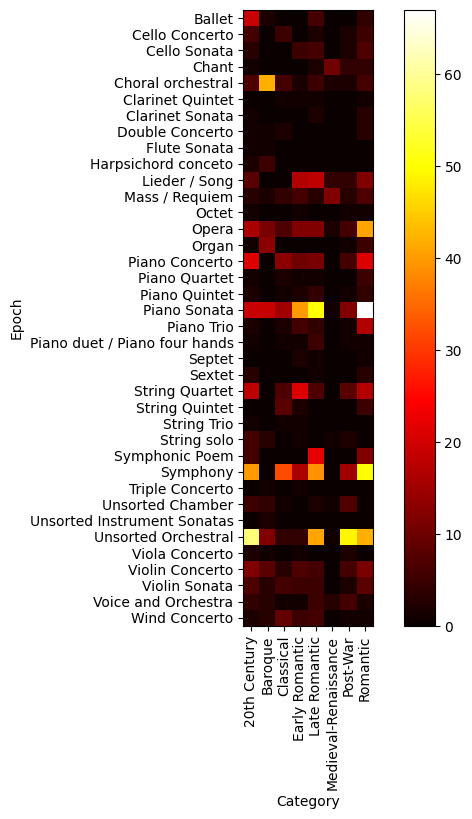

In [10]:
# Calculate contingency table
contingency_table = pd.crosstab(df['category'], df['epoch'])

# Create heatmap
plt.figure(figsize=(8,8))
plt.imshow(contingency_table, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks

plt.xlabel('Category')
plt.ylabel('Epoch')
plt.xticks(range(len(contingency_table.columns)), contingency_table.columns, rotation=90)
plt.yticks(range(len(contingency_table.index)), contingency_table.index)

# Show the plot
plt.show()

---

<b> b)</b> **Izračunajte** udaljenosti među stilskim razdobljima koristeći *totalnu varijacijsku udaljenost*. 
Neka je $C$ kontingencijska matrica dimenzija $N \times M$, te neka su kategorije skladbi raspoređene po retcima, a stilska razdoblja po stupcima. Totalna varijacijska daljenost između dva stilska razdboblja $i$ i $j$ računa se kao
$$
\delta_{i,j} = \frac{1}{2} \sum_{k=1}^N \left\lvert \frac{C_{k,i}}{S_i} - \frac{C_{k,j}}{S_j} \right\rvert,
$$
gdje je $S_i = \sum_{k=1}^N C_{k,i}$. **Izračunajte i prikažite** matricu udaljenosti $\Delta$ čiji elementi su $\Delta_{i, j} = \delta_{i, j}$. <br>
Provjerite koji parovi kategorija su najsličniji, a koji najrazličitiji.

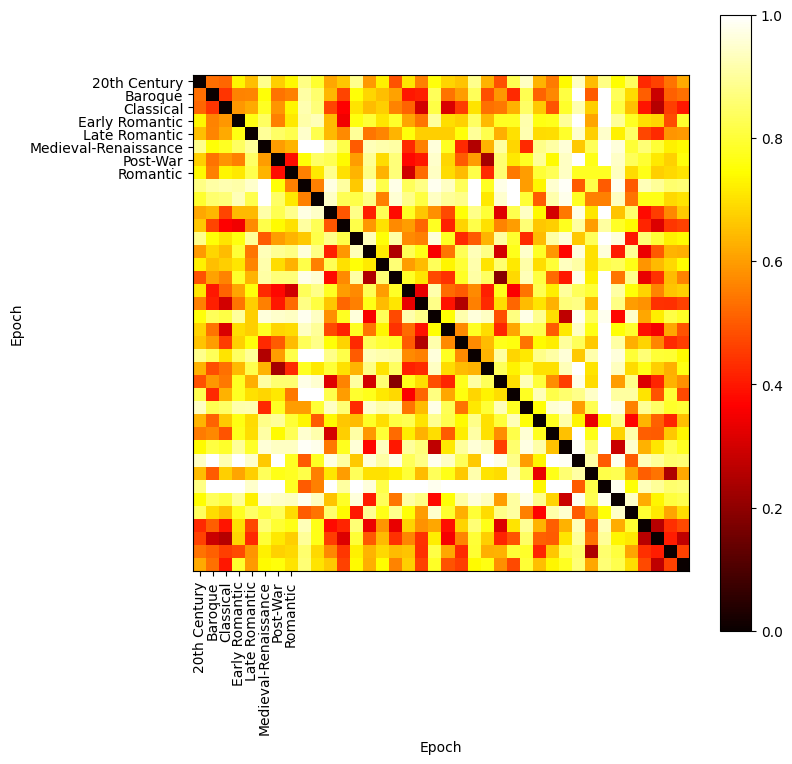

In [11]:
# Calculate the total variation distance matrix
distance_matrix = squareform(pdist(contingency_table, 'braycurtis'))

# Create heatmap for the distance matrix
plt.figure(figsize=(8, 8))
plt.imshow(distance_matrix, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks
plt.xlabel('Epoch')
plt.ylabel('Epoch')
plt.xticks(range(len(contingency_table.columns)), contingency_table.columns, rotation=90)
plt.yticks(range(len(contingency_table.columns)), contingency_table.columns)

# Show the plot
plt.show()

---

<b>c)</b>
Provedite postupak klasičnog, <b>metričnog višedimenzionalnog skaliranja,</b> koristeći prethodno dobivenu <b>matricu udaljenosti.</b><br>
**Prikažite** kategorije na grafu raspršenja s **dvije dimenzije** i **označite** koju kategoriju pojedina točka predstavlja. 
<b>Ispišite</b> <i>stress</i> vrijedost.<br>
Uočavate li smisleno grupiranje kategorija prema njihovom povijesnom slijedu?

--- 

<b>d)</b> Neka je $\mathbf C$ kontingencijska tablica s početka ovog zadatka.
Neka je mjera sličnosti između dvaju stilskih razdoblja $i$ i $j$ definirana na način:
\begin{equation}
\mathit{sim}\left(i, j\right) = \sum_{k = 0}^N \frac{\min \left\{C_{k, i}, C_{k, j} \right\}}{\max \left\{C_{k, i}, C_{k, j}\right\}}
\end{equation}
<b>Izračunajte sličnosti</b> između svih parova stilskih razdoblja. Zatim, sami izvedite neku mjeru različitosti temeljem izračunate mjere sličnosti.
Konačno, <b>izračunajte matricu različitosti</b> koja sadrži različitosti svih parova stilskih razdoblja.<br>
Kako se rezultati razlikuju u odnosu na 3. b)?

---

<b>e)</b>
Provedite postupak <b>nemetričnog višedimenzionalnog skaliranja,</b> koristeći prethodno dobivenu <b>matricu različitosti.</b> <br>
**Prikažite** kategorije na grafu raspršenja s **dvije dimenzije** i **označite** koju kategoriju pojedina točka predstavlja. 
<b>Ispišite</b> <i>stress</i> vrijedost.<br>
Uočavate li smisleno grupiranje kategorija prema njihovom povijesnom slijedu?

---

## 4. Analiza korespondencije

<b>a) </b>
**Kreirajte** novi podskup podataka tako da sadrži samo skladbe **prvih 5&ndash;10 skladatelja** po nekom kriteriju &mdash; proizvoljno odaberite kriterij po kojemu ćete ih poredati (npr. ukupan broj skladbi, ukupan broj glasova po svim skladbama, prosječan broj glasova po svim skladbama, ili samo odaberite 5&ndash;10 skladatelja po vlastitom izboru).
Zatim **odredite** koje kategorije skladbi se najčešće pojavljuju u dobivenom podskupu, te unutar njega zadržite samo skladbe koje pripadaju otprlike **5&ndash;10 najčešćih kategorija**.

In [12]:


# Calculate the number of compositions per composer
composer_counts = df['composer'].value_counts()

# Get the top 5 composers
top_composers = composer_counts.nlargest(5).index

# Filter the dataset to keep only the compositions by the top 5 composers
filtered_df = df[df['composer'].isin(top_composers)]
composers  = filtered_df['composer'].unique()
print(composers)
# Print the filtered dataset
#print(filtered_df)
# Calculate the number of compositions per category
category_counts = filtered_df['category'].value_counts()

# Get the top 5 categories
top_categories = category_counts.nlargest(5).index

# Filter the dataset to keep only the compositions in the top 5 categories
filtered_df = filtered_df[filtered_df['category'].isin(top_categories)]

# Print the filtered dataset
categories  = filtered_df['category'].unique()
print(categories)

['Wolfgang Amadeus Mozart' 'Ludwig van Beethoven' 'Johann Sebastian Bach'
 'Johannes Brahms' 'Franz Schubert']
['Symphony' 'Piano Sonata' 'Choral orchestral' 'String Quartet'
 'Lieder / Song']


---

U nastavku vježbe koristite ovako generirani podskup podataka.

<b>b)</b>**Izračunajte i prikažite** kontingencijsku tablicu između skladatelja i kategorije skladbi koje su napisali.


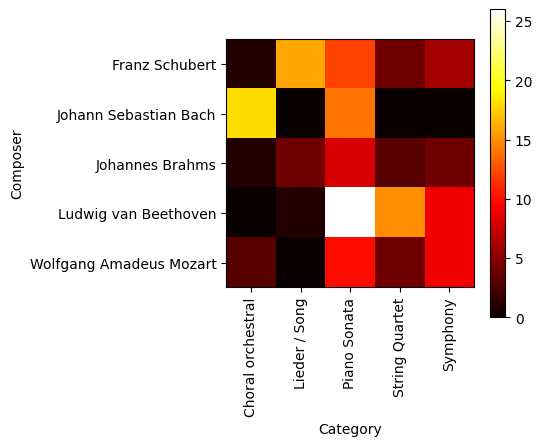

In [13]:
# Calculate contingency table
contingency_table = pd.crosstab(filtered_df['composer'], filtered_df['category'])

# Create heatmap
plt.figure(figsize=(4,4))
plt.imshow(contingency_table, cmap='hot', interpolation='nearest')
plt.colorbar()

# Set labels and tick marks

plt.xlabel('Category')
plt.ylabel('Composer')
plt.xticks(range(len(contingency_table.columns)), contingency_table.columns, rotation=90)
plt.yticks(range(len(contingency_table.index)), contingency_table.index)

# Show the plot
plt.show()

---

<b>c)</b> **Prikažite** graf raspršenja analize korespondencije između varijabli `composer` i `category` koristeći prve dvije komponente. 
Jasno <b>označite</b> (bojom i oblikom markera, ili natpisima) kojeg skladatelja, odnosno kategoriju, predstavlja pojedina točka.
<b>Ispišite</b> udjele objašnjene varijance za sve komponente, te ukupnu inerciju.
Također, na grafu <b>označite ishodište</b> radi lakše interpretacije. <br>
Obratite pozornost na objašnjenu varijancu temeljem prve dvije komponente. Na temelju dobivenog grafa i kontingencijske tablice iz prethodnog zadatka pokušajte odgovoriti na sljedeća pitanja:

-   Koji skladatelji se najviše izdvajaju po pojedinoj kategoriji?
-   Koji skladatelji su određenu kategoriju skladbi pisali znatno više ili manje u usporedbi s drugim skladateljima?
-   Koji skladatelji su određenu kategoriju skladbi pisali znatno više ili manje u usporedbi s drugim kategorijama?
-   Koji skladatelji su pisali prosječan broj skladbi u svim kategorijama?

---

<b>d)</b> <b>Provedite analizu korespondencije</b> između varijabli `country` i `epoch`.
U obzir uzmite <b>reducirani skup podataka</b> koji sadrži samo sljedeće države: `["Germany", "Austria", "Italy", "France", "Hungary", "Russia", "United States"]`.
<b>Prikažite graf</b> kao i u prethodnom podzadatku, te <b>ispišite</b> udjele objašnjene varijance i ukupnu inerciju.
Što možete zaključiti o odnosima država i stilskih razdoblja pomoću grafa?